# Event Study Analysis: Centrality and Volatility
## Examining Two Exogenous Shocks to Ethereum Validator Centrality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('../data/processed/daily_regression_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

print(f"Data range: {df['date'].min()} to {df['date'].max()}")
print(f"Total observations: {len(df)}")

Data range: 2020-07-13 00:00:00 to 2025-07-22 00:00:00
Total observations: 1836


## Define Event Dates

1. **Nethermind Bug** (Jan 21, 2024): Client bug knocked out 8% of validators
2. **Shanghai Upgrade** (April 12, 2023): Enabled validator withdrawals

In [2]:
# Define events
events = {
    'Nethermind Bug': '2024-01-21',
    'Shanghai Upgrade': '2023-04-12'
}

# Event window: 7 days before and after
window = 7

def get_event_window(df, event_date, window=7):
    """Extract data around event date"""
    event_date = pd.to_datetime(event_date)
    start = event_date - pd.Timedelta(days=window)
    end = event_date + pd.Timedelta(days=window)
    
    event_data = df[(df['date'] >= start) & (df['date'] <= end)].copy()
    event_data['days_from_event'] = (event_data['date'] - event_date).dt.days
    
    return event_data

## Event Study Analysis Function

In [3]:
def analyze_event(df, event_name, event_date, window=7):
    """Analyze single event with statistics and visualization"""
    
    # Get event window data
    event_df = get_event_window(df, event_date, window)
    
    if len(event_df) == 0:
        print(f"No data available for {event_name}")
        return None
    
    # Split pre/post event
    pre = event_df[event_df['days_from_event'] < 0]
    post = event_df[event_df['days_from_event'] > 0]
    
    # Calculate statistics
    results = {}
    for var in ['top20_mean', 'top20_std', 'prof_garman_klass_vol']:
        pre_mean = pre[var].mean()
        post_mean = post[var].mean()
        change = post_mean - pre_mean
        pct_change = (change / pre_mean) * 100 if pre_mean != 0 else 0
        
        # T-test
        t_stat, p_val = stats.ttest_ind(post[var].dropna(), pre[var].dropna())
        
        results[var] = {
            'pre_mean': pre_mean,
            'post_mean': post_mean,
            'change': change,
            'pct_change': pct_change,
            't_stat': t_stat,
            'p_value': p_val
        }
    
    # Print results
    print("\n" + "="*80)
    print(f"EVENT: {event_name} ({event_date})")
    print("="*80)
    print(f"\nSample: {len(pre)} days pre-event, {len(post)} days post-event\n")
    
    print(f"{'Variable':<25} {'Pre-Mean':>12} {'Post-Mean':>12} {'Change':>12} {'% Change':>10} {'p-value':>10}")
    print("-"*85)
    
    for var, res in results.items():
        var_name = var.replace('_', ' ').title()
        print(f"{var_name:<25} {res['pre_mean']:>12.4f} {res['post_mean']:>12.4f} {res['change']:>12.4f} {res['pct_change']:>9.2f}% {res['p_value']:>10.4f}")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f'{event_name} - Event Study ({event_date})', fontsize=14, fontweight='bold')
    
    vars_to_plot = [
        ('top20_mean', 'Top20 Mean Centrality'),
        ('top20_std', 'Top20 Std Centrality'),
        ('prof_garman_klass_vol', 'Volatility (GK)')
    ]
    
    for ax, (var, title) in zip(axes, vars_to_plot):
        ax.plot(event_df['days_from_event'], event_df[var], marker='o', linewidth=2, markersize=6)
        ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Event')
        ax.axhline(results[var]['pre_mean'], color='blue', linestyle=':', alpha=0.5, label='Pre-event avg')
        ax.axhline(results[var]['post_mean'], color='green', linestyle=':', alpha=0.5, label='Post-event avg')
        ax.set_xlabel('Days from Event', fontweight='bold')
        ax.set_ylabel(title, fontweight='bold')
        ax.set_title(f"{title}\n(Δ={results[var]['pct_change']:.1f}%, p={results[var]['p_value']:.3f})")
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return results

## Event 1: Nethermind Client Bug (January 21, 2024)

**Hypothesis**: Bug knocking out 8% of validators should **increase centrality** and **increase volatility**


EVENT: Nethermind Bug (2024-01-21)

Sample: 7 days pre-event, 7 days post-event

Variable                      Pre-Mean    Post-Mean       Change   % Change    p-value
-------------------------------------------------------------------------------------
Top20 Mean                      4.6268       4.6871       0.0603      1.30%     0.0745
Top20 Std                       8.6941       9.3990       0.7049      8.11%     0.2554
Prof Garman Klass Vol           0.0207       0.0246       0.0039     18.80%     0.5186


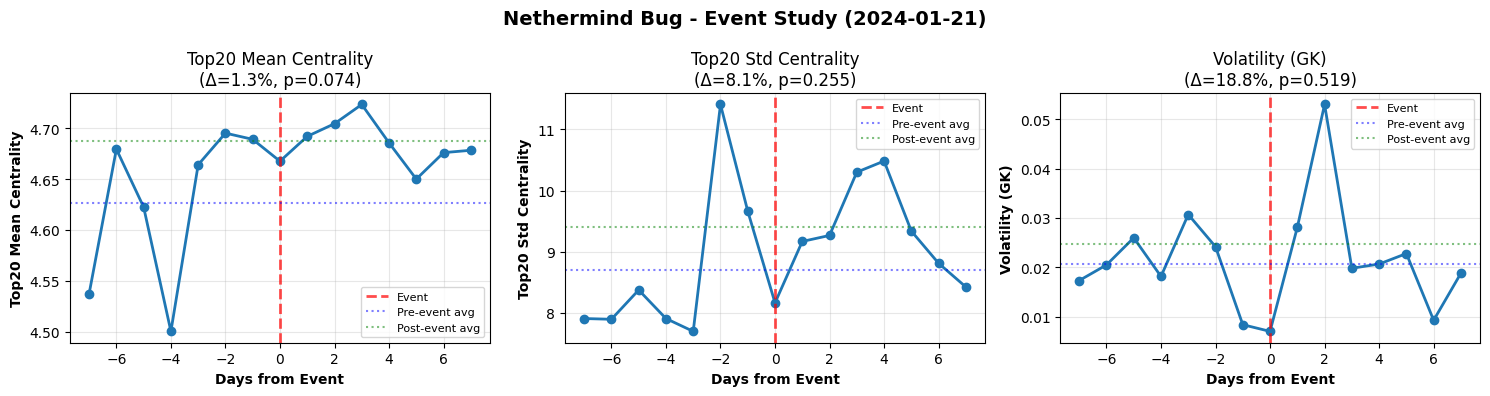

In [4]:
results_nethermind = analyze_event(df, 'Nethermind Bug', events['Nethermind Bug'], window)

## Event 2: Shanghai Upgrade (April 12, 2023)

**Hypothesis**: Enabling withdrawals increases validator mobility/competition, should **decrease centrality** and **decrease volatility**


EVENT: Shanghai Upgrade (2023-04-12)

Sample: 7 days pre-event, 7 days post-event

Variable                      Pre-Mean    Post-Mean       Change   % Change    p-value
-------------------------------------------------------------------------------------
Top20 Mean                      4.2453       4.1828      -0.0625     -1.47%     0.1713
Top20 Std                       5.5237       5.0457      -0.4780     -8.65%     0.0086
Prof Garman Klass Vol           0.0165       0.0223       0.0059     35.58%     0.1346


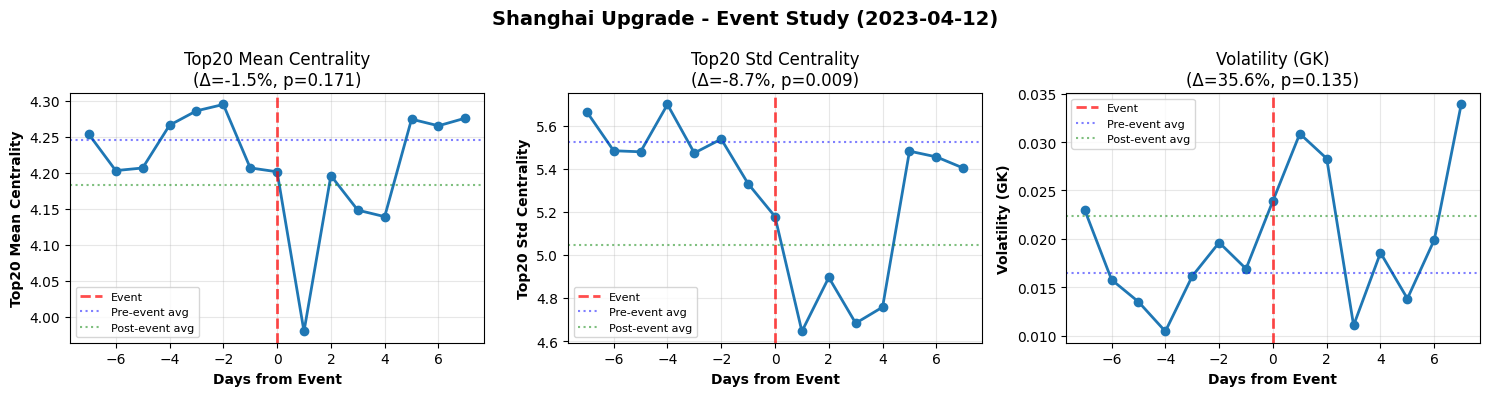

In [5]:
results_shanghai = analyze_event(df, 'Shanghai Upgrade', events['Shanghai Upgrade'], window)

## Summary Comparison Across All Events


SUMMARY: All Events Comparison

           Event   Mean_Δ%   Mean_p    Std_Δ%    Std_p    Vol_Δ%    Vol_p
  Nethermind Bug  1.302703 0.074462  8.107644 0.255379 18.799092 0.518637
Shanghai Upgrade -1.473294 0.171347 -8.653142 0.008643 35.582423 0.134640


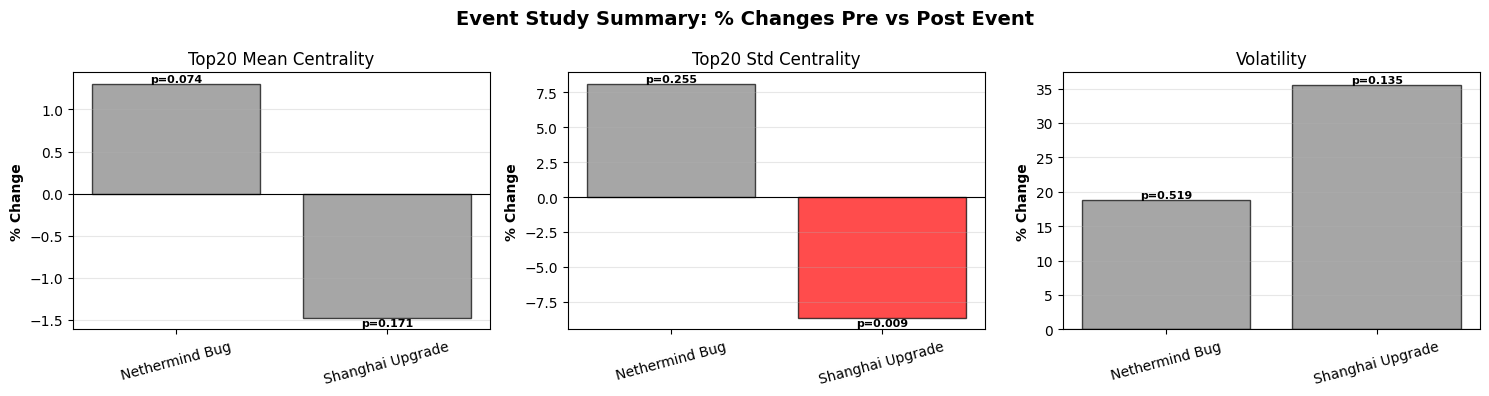


Note: Red bars indicate statistically significant changes (p < 0.05)


In [6]:
# Compile results
summary_data = []

all_results = [
    ('Nethermind Bug', results_nethermind),
    ('Shanghai Upgrade', results_shanghai)
]

for event_name, results in all_results:
    if results:
        summary_data.append({
            'Event': event_name,
            'Mean_Δ%': results['top20_mean']['pct_change'],
            'Mean_p': results['top20_mean']['p_value'],
            'Std_Δ%': results['top20_std']['pct_change'],
            'Std_p': results['top20_std']['p_value'],
            'Vol_Δ%': results['prof_garman_klass_vol']['pct_change'],
            'Vol_p': results['prof_garman_klass_vol']['p_value']
        })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("SUMMARY: All Events Comparison")
print("="*80 + "\n")
print(summary_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Event Study Summary: % Changes Pre vs Post Event', fontsize=14, fontweight='bold')

metrics = [
    ('Mean_Δ%', 'Mean_p', 'Top20 Mean Centrality'),
    ('Std_Δ%', 'Std_p', 'Top20 Std Centrality'),
    ('Vol_Δ%', 'Vol_p', 'Volatility')
]

for ax, (metric, p_col, title) in zip(axes, metrics):
    colors = ['red' if p < 0.05 else 'gray' for p in summary_df[p_col]]
    bars = ax.bar(summary_df['Event'], summary_df[metric], color=colors, alpha=0.7, edgecolor='black')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_ylabel('% Change', fontweight='bold')
    ax.set_title(title)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=15)
    
    # Add p-value labels
    for bar, p_val in zip(bars, summary_df[p_col]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'p={p_val:.3f}',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nNote: Red bars indicate statistically significant changes (p < 0.05)")

## Interpretation Guide

### Expected Patterns:

1. **Nethermind Bug (Jan 2024)**:
   - Centrality should ↑ (fewer validators → more concentrated)
   - Volatility should ↑ (reduced network stability)

2. **Shanghai Upgrade (April 2023)**:
   - Centrality should ↓ (increased validator mobility/competition)
   - Volatility should ↓ (healthier validator distribution)

### Statistical Significance:
- **p < 0.05**: Strong evidence of event impact
- **p < 0.10**: Moderate evidence of event impact
- **p > 0.10**: Weak/no evidence of event impact